# This is a notebook highlighting some of the problems with using SVD before a linear model

Which is equivalent to PCA (Principal Component Analysis).

Let's recall our old friend [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition). 

SVD is an *extremely powerful tool*. In short, you can decompose any real or complex matrix into three main components:

\begin{equation}
    \bf{X} = \bf{ U \Sigma V^{*}}
\end{equation}

Where: 

- $\bf{X}$ is an (n x k) matrix 
- $\bf{U}$ is a (n x n) unitary matrix 
- $\bf{\Sigma}$ is an (k x n) diagonal matrix with non-negative real numbers on the diagonal and 
- $\bf{V^{*}}$ is also a (k x k) conjugate transpose of the (k x k) unitary matrix $\bf{V}$.

The diagonal entries $\sigma_i$ of $\bf{\Sigma}$ are the singular values of $\bf{X}$, which can be related to eigenvalue decomposition of $\bf{X^{T}X}$ by the following fact:

\begin{equation}
    \bf{X^{T} X} =  \bf{ V (\Sigma^{*}\Sigma) V^{*}} = \bf{Q \Lambda Q^{T}}.
\end{equation}

Where:

- The columns of $\bf{V}$ (the right-singular vectors) are the eigenvectors of $\bf{X^{T}X}$.
- The non-zero elements of $\bf{\Sigma}$ are the square roots of the non-zero eigenvalues of $\bf{X^{T}X}$.
- Note also that for symmetric matrix  $\bf{V^{*}}$ = $\bf{V^{-1}}$ = $\bf{V^{T}}$ 
- Note that $\bf{U}$ = $\bf{V}$ = $\bf{Q}$ and that $\bf{U}\bf{U}^T = \bf{V}\bf{V}^T = \bf{I}$

It's worth recalling the ordinary least-squares estimators, also known as the normal equations:

\begin{equation}
    \bf{\beta} = (\bf{X^{T} X})^{-1}  \bf{X^{T} Y}
\end{equation}
Which is modeling $\bf{Y}$, where $\bf{Y}=[y_1,y_2,...,y_n]^T$ simply as
\begin{equation}
    \bf{Y} = \bf{\beta^{T}} \bf{X} + \bf{\epsilon}
\end{equation}
Where $\bf{\epsilon}$ is some (typically) assumed Gaussian distributed error term and $\bf{X}$ are some set of features/predictors/input variables. 

Now let's recall a commonly used technique for dimensionality reduction: [*Principal Component Analysis (PCA)*](https://en.wikipedia.org/wiki/Principal_component_analysis). 

According to Wiki, "PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables. 

As it turns out, PCA and SVD are related in the following way:

\begin{equation}
    \bf{T} = \bf{XV}
\end{equation}
\begin{equation}
    \bf{T} = \bf{U \Sigma V^{T} V}
\end{equation}
\begin{equation}
    \bf{T} = \bf{U \Sigma}
\end{equation}

\begin{equation}
    \bf{T_r} = \bf{U_r \Sigma_r} = \bf{X V_r}
\end{equation}

Where $\bf{T}$ denotes the score matrix, and $\bf{T_r}$ denotes the score matrix approximated up to $\bf{r}$  components, which is then $(n x r)$. 

This is particularly interesting because ${\bf{T}_r}$ turns out to be the optimal encoding for a fixed number $r$ components of $\bf{X}$ when using the Frobenious norm as your distance metric, or more formally

\begin{equation}
\bf{T}_r = \underset{\bf{T}}{\operatorname{argmin}} \bf{\Delta}_{k-r} = \underset{\bf{T}}{\operatorname{argmin}}  \|\bf{X}\bf{T}\|_F= \underset{\bf{T}}{\operatorname{argmin}}\|\bf{T}V^T - \bf{T}_r \bf{V}_r^T \|_{2}^2
\end{equation}

Where $\bf{\Delta}_{k-r}$ can be considered our reconstruction error of the original matrix, and clearly as $k \to r , \Delta_{k-r} \to 0$.

I've seen people use PCA when building a predictive model by using the approximated score matrix as the input to a linear model. I wouldn't say it's a terribly wrong practice but we lose information in doing this. 

Suppose we took an $r$ rank approximation of our original input matrix and suppose further that it's true rank was $k$ ($k>>r$). Clearly, $\bf{T_r}$ will be our input, which would give us

\begin{equation}
\bf{\beta} = (\bf{X^{T} X})^{-1}  \bf{X^{T} Y} = (\bf{T_r^T T_r})^{-1} \bf{ T_r^{T} Y} )
\end{equation}

Here's where things can go wrong, we can pathologically define some outcome of interest where our outcome is *exactly* our reconstruction error times some weight matrix (let's call it $\bf{W}, \bf{W}$ is $(k x 1)$), setting $\bf{Y} = \Delta_{k-r}\bf{W}$ we would get

\begin{equation}
\bf{\beta} = (\bf{T_r^T} \bf{T_r})^{-1} \bf{T_r}^{T} \bf{\Delta}_{k-r}\bf{W}
\end{equation}


For the linear model, using the normal equations minmizes the sum of squared errors, which means we have the following

\begin{equation}
\bf{SSE}(\bf{\beta}) = (\bf{Y} - \bf{\beta} \bf{X})^T (\bf{Y}-\bf{\beta} \bf{X})
\end{equation}
Let's look at a single term 
\begin{equation}
\bf{Y}-\bf{\beta}^T \bf{X} =\bf{Y} - ((\bf{T}_r^T \bf{T}_r)^{-1} \bf{T}_r^{T} \bf{\Delta}_{k-r}\bf{W})^T \bf{T}_r
\end{equation}

\begin{equation}
=\bf{\Delta}_{k-r}\bf{W} - \big ((\bf{T}_r^T \bf{T}_r)^{-1} \bf{T}_r^{T} \bf{\Delta}_{k-r}\bf{W} \big)^T \bf{T}_r
\end{equation}

What's going to happen here? Well, recall that $\bf{T_r}$ was an orthogonal transformation, which means that $\bf{T}_r^{T} \bf{\Delta}_{k-r}=0$, which means the entire term will be 0! That means our error will be $ \bf{\Delta}_{k-r}\bf{W}$! So, this means that our model will completely wrong! 

I know, I know. This is a pathological example, so it's not true in general, but it's insightful about what the underelying implications are and it puts a bound on how badly things can go when using a pipeline of this nature. In general, the information you'll lose will likely be smaller but not always. 

Intuitively, this makes sense because our Eigenvalue Decomposition (PCA) is only looking at the variation of our features $\bf{X}$ and is encoding it in such a way that it keeps the maximum variation of our original matrix, but that may or may not have anything to do with the variation with our label/outcome $\bf{Y}$.

So, I would summarize the main points as:

1. PCA is super useful for many, many things but it's probably not appropriate for supervised learning
2. At the extreme case, using PCA for a linear model can result in a 0% accuracy (measured via rmse or whatever works for you)
3. There are many supervised learning tools for dimensionality reduction that will do better than PCA (e.g., Lasso Regression)

Lets define some $\Delta$ that can be considered our reconstruction error of the original matrix. Simply

\begin{equation}
    \Delta_{k-r} = \bf{X V_k}-\bf{U_r \Sigma_r} = \bf{X V_k} - \bf{T_r}.
\end{equation}

And obviously as $k \to r \Rightarrow \Delta_{k-r} \to 0$.

I've previously seen people use PCA before building a predictive model by using the approximated Score Matrix as the input to a linear model. I wouldn't say it's a terribly wrong practice but we lose information in doing this. Suppose we took an $r$ rank approximation of our original input matrix and suppose further that it's true rank was $k$ ($k>>r$). Clearly, $\bf{T_r}$ will be our input, which would give us

\begin{equation}
\bf{\beta} = (\bf{X^{T} X})^{-1}  \bf{X^{T} Y} = (\bf{T_r^T T_r})^{-1} \bf{ T_r^{T} Y} )
\end{equation}

Here's where things can go wrong, we can pathologically define some outcome of interest where our outcome is *exactly* our reconstruction error, setting $\bf{Y} = \Delta_{k-r}$ we would get

\begin{equation}
\bf{\beta} = (\bf{T_r^T T_r})^{-1} \bf{ T_r^{T} Y} ) 
\end{equation}
\begin{equation}
\bf{\beta} = (\bf{T_r^T T_r})^{-1} \bf{ \Delta_{k-r}} ) 
\end{equation}
\begin{equation}
= (\bf{T_r^T T_r})^{-1} \bf{ T_r^{T}(\bf{X V_k} - \bf{T_r}) } )
\end{equation}
\begin{equation}
= (\bf{T_r^T T_r})^{-1}( \bf{ T_r^{T}\bf{X V_k} -  T_r^{T}\bf{T_r} })
\end{equation}
\begin{equation}
= (\bf{(X V_r)^T X V_r})^{-1}( \bf{ T_r^{T}\bf{X V_k} -  \bf{(X V_r)}^{T}\bf{X V_r} })
\end{equation}
\begin{equation}
= (\bf{V_r^T X^T  X V_r})^{-1}( \bf{ T_r^{T}\bf{X V_k} -  \bf{V_r}^{T}\bf{X}^T \bf{X V_r} })
\end{equation}
\begin{equation}
\bf{\beta}= (\bf{V_r^T X^T  X V_r})^{-1}\bf{ V_r}^{T}X^{T}\bf{X V_k} -  (\bf{V_r^T X^T  X V_r})^{-1} \bf{V_r}^{T}\bf{X}^T \bf{X V_r} 
\end{equation}
\begin{equation}
\bf{\beta}= (\bf{V_r^T X^T  X V_r})^{-1}\bf{ V_r}^{T}X^{T}\bf{X V_k} -  1
\end{equation}

Now what happens when we make a prediction

\begin{equation}
\hat{\bf{Y}} = \bf{\beta}^T\bf{X}
\end{equation}
Substituting our previous work above we get
\begin{equation}
\hat{\bf{Y}}= ((\bf{V_r^T X^T  X V_r})^{-1}\bf{ V_r}^{T}X^{T}\bf{X V_k} -  1)\bf{X}
\end{equation}
\begin{equation}
\hat{\bf{Y}}= ((\bf{V_r^T X^T  X V_r})^{-1}\bf{ V_r}^{T}X^{T}\bf{X V_k})\bf{X} -  X)
\end{equation}

So what is the first term of $\hat{\bf{Y}}$? Well, that's the ratio of our $r$ rank approximation squared and the product of our full matrix, which will clearly always be greater than 1.

So now $\bf{}

Here's where I want to say that this will essentially yield an R-Square of zero.

Maybe I'll look at 

\begin{equation}
\bf{RSS}(\bf{\beta}) = (\bf{Y} - \bf{\beta} \bf{X})^T (\bf{Y}-\bf{\beta} \bf{X})
\end{equation}

Let's look at a singe $(\bf{Y} - \bf{\beta} \bf{X})$
\begin{equation}
(\bf{Y} - \bf{\beta} \bf{X})
\end{equation}

\begin{equation}
\bf{Y} - ((\bf{V_r^T X^T  X V_r})^{-1}\bf{ V_r}^{T}X^{T}\bf{X V_k})\bf{X} -  X)
\end{equation}

\begin{equation}
\bf{\Delta}_{k-r} - ((\bf{V_r^T X^T  X V_r})^{-1}\bf{ V_r}^{T}X^{T}\bf{X V_k})\bf{X} -  X)
\end{equation}

\begin{equation}
(\bf{X V_k} -\bf{X V_r}) - ((\bf{V_r^T X^T  X V_r})^{-1}\bf{ V_r}^{T}X^{T}\bf{X V_k})\bf{X} -  X)
\end{equation}
Now let's look at the whole thing (y-xb)^T(y-xb)
\begin{equation}
[(\bf{X V_k} -\bf{X V_r}) - ((\bf{V_r^T X^T  X V_r})^{-1}\bf{ V_r}^{T}X^{T}\bf{X V_k})\bf{X} -  X)]^T [(\bf{X V_k} -\bf{X V_r}) - ((\bf{V_r^T X^T  X V_r})^{-1}\bf{ V_r}^{T}X^{T}\bf{X V_k})\bf{X} -  X)]
\end{equation}



Let's look at it from a different angle

\begin{equation}
\bf{\Delta}_{k-r} - (\bf{T_r^T T_r})^{-1} \bf{ \Delta_{k-r}}  = (\bf{X V_k} - \bf{T_r})- (\bf{T_r^T T_r})^{-1} \bf{ (\bf{X V_k} - \bf{T_r})} )  
\end{equation}


\begin{equation}
(\bf{X V_k} - \bf{T_r})- ((\bf{T_r^T T_r})^{-1}\bf{X V_k}  - (\bf{T_r^T T_r})^{-1} \bf{T_r})
\end{equation}
\begin{equation}
\bf{T_k} - \bf{T_r} - ((\bf{T_r^T T_r})^{-1}\bf{T_k}  - (\bf{T_r^T T_r})^{-1} \bf{T_r})
\end{equation}

\begin{equation}
\bf{T_k} - \bf{T_r} - (\bf{T_r^T T_r})^{-1}\bf{T_k}  + (\bf{T_r^T T_r})^{-1} \bf{T_r}
\end{equation}

\begin{equation}
\bf{T_k}(1-\bf{T_r^T T_r})^{-1}) - \bf{T_r}(1-(\bf{T_r^T T_r})^{-1})
\end{equation}

\begin{equation}
[\bf{T_k}(1-\bf{T_r^T T_r})^{-1}) - \bf{T_r}(1-(\bf{T_r^T T_r})^{-1})]^T [\bf{T_k}(1-\bf{T_r^T T_r})^{-1}) - \bf{T_r}(1-(\bf{T_r^T T_r})^{-1})]
\end{equation}

Let $\bf{T_K} = \bf{T_k}(1-(\bf{T_r^T T_r})^{-1}$) and $\bf{T_R}= \bf{T_r}(1-(\bf{T_r^T T_r})^{-1})$

\begin{equation}
(\bf{T}_K - \bf{T}_R)^T (\bf{T}_K - \bf{T}_R) = (\bf{T}_K^T - \bf{T}_R^T) (\bf{T}_K - \bf{T}_R)
\end{equation}
\begin{equation}
\bf{T}_K^T \bf{T}_K - \bf{T}_K^T \bf{T}_R - \bf{T}_R^T\bf{T}_K + \bf{T}_R^T \bf{T}_R
\end{equation}
\begin{equation}
\bf{T}_K^T \bf{T}_K - 2\bf{T}_R^T\bf{T}_K + \bf{T}_R^T \bf{T}_R
\end{equation}
I need to show that this is zero
\begin{equation}
[\bf{T_k}(1-(\bf{T_r^T T_r})^{-1})]^T[\bf{T_k}(1-(\bf{T_r^T T_r})^{-1})] - 2[\bf{T_r}(1-(\bf{T_r^T T_r})^{-1})]^T[\bf{T_k}(1-(\bf{T_r^T T_r})^{-1})] + [\bf{T_r}(1-(\bf{T_r^T T_r})^{-1})]^T [\bf{T_r}(1-(\bf{T_r^T T_r})^{-1})]
\end{equation}


Let's look at the first term
\begin{equation}
Term_1 = [\bf{T_k}(1-(\bf{T_r^T T_r})^{-1})]^T[\bf{T_k}(1-(\bf{T_r^T T_r})^{-1})] 
\end{equation}
\begin{equation}
Term_1 = [(\bf{1}-(\bf{T_r^T T_r})^{-1})^T \bf{T_k}^T] [\bf{T_k}(1-(\bf{T_r^T T_r})^{-1})] 
\end{equation}

\begin{equation}
Term_1 = [\bf{T_k}^T - \bf{T_k}^T (\bf{T_r^T T_r})^{-1}] [\bf{T_k}-\bf{T_k}(\bf{T_r^T T_r})^{-1}] 
\end{equation}

\begin{equation}
Term_1 = \bf{T_k}^T\bf{T_k} - 2\bf{T_k}(\bf{T_r^T T_r})^{-1} + \bf{T_k}^T (\bf{T_r^T T_r})^{-1}\bf{T_k}(\bf{T_r^T T_r})^{-1}
\end{equation}
\begin{equation}
Term_1 = \bf{T_k}^T\bf{T_k} - 2\bf{T_k}(\bf{T_r^T T_r})^{-1} + \bf{T_k}^T\bf{T_k} (\bf{T_r^T T_r})^{-1}(\bf{T_r^T T_r})^{-1}
\end{equation}


$T_k ^T T_k = X^T V_k^T X V_k =  X^TX V_k V_k^T$ = $X^TX$

$T_r^T T_r =  V_r^TX^T X V_r$

Some substitution yields,
\begin{equation}
    \bf{Y} = \bf{\beta^{T}} \bf{X} + \bf{\epsilon}
\end{equation}


\begin{equation}
    \bf{Y} = (\bf{V (\Sigma^{*}\Sigma) V^{*}})^{-1}  ( U \Sigma V^{*} )^{T} \bf{Y X} + \bf{\epsilon}
\end{equation}


\begin{equation}
    \bf{Y} = (\bf{V (\Sigma^{T}\Sigma) V^{T}})^{-1}  \bf{V \Sigma U^{T} } \bf{Y}\bf{ U \Sigma V^{T}}+ \bf{\epsilon}
\end{equation}


\begin{equation}
    \bf{Y} = \bf{V^{T} (\Sigma^{T}\Sigma)^{-1} V}  V \Sigma \bf{ U^{T}}\bf{Y}\bf{ U \Sigma V^{T}}+ \bf{\epsilon}
\end{equation}


\begin{equation}
    \bf{Y} = \bf{V^{T} (\Sigma^{T}\Sigma)^{-1} V}  \bf{ V \Sigma U^{T}}\bf{Y}\bf{ U \Sigma V^{T}}+ \bf{\epsilon}
\end{equation}


\begin{equation}
    \bf{Y} = \bf{V^{T} (\Sigma^{T}\Sigma)^{-1} V}  \bf{ V \Sigma U^{T}}\bf{Y}\bf{ U \Sigma V^{T}}+ \bf{\epsilon}
\end{equation}

I'll say something interesting about this result in a minute.

Now let's recall a commonly used technique for dimensionality reduction: [*Principal Component Analysis (PCA)*](https://en.wikipedia.org/wiki/Principal_component_analysis). 

According to Wiki, "PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables. 

As it turns out, PCA and SVD are related in the following way:

\begin{equation}
    \bf{T} = \bf{XV}
\end{equation}
\begin{equation}
    \bf{T} = \bf{U \Sigma V^{T} V}
\end{equation}
\begin{equation}
    \bf{T} = \bf{U \Sigma}
\end{equation}

\begin{equation}
    \bf{T_r} = \bf{U_r \Sigma_r} = \bf{X V_r}
\end{equation}

Where $\bf{T}$ denotes the score matrix, and $\bf{T_r}$ denotes the score matrix approximated up to $\bf{r}$  components. 

I've previously seen people use PCA before building a predictive model by using the approximated Score Matrix as the input to a linear model. I wouldn't say it's a terribly wrong practice but we lose information in doing this. Suppose we took an $r$ rank approximation of our original input matrix and suppose further that it's true rank was $k$ ($k>>r$). Clearly, $\bf{T_r}$ will be our input, which would give us

\begin{equation}
\bf{\beta} = (\bf{X^{T} X})^{-1}  \bf{X^{T} Y} = (\bf{T_r^T T_r})^{-1} \bf{ T_r^{T} Y} )
\end{equation}

Here's where things can go wrong, we can pathologically define some outcome of interest where our outcome is *exactly* our reconstruction error. Lets define some $\Delta$ that can be considered our reconstruction error of the original matrix. Simply

\begin{equation}
    \Delta_{k-r} = \bf{X V_k}-\bf{U_r \Sigma_r} = \bf{X V_k} - \bf{T_r}.
\end{equation}

And obviously as $k \to r \Rightarrow \Delta_{k-r} \to 0$.

Now what happens, well if we substitute this for $\bf{Y}$ we would get

\begin{equation}
\bf{\beta} = (\bf{T_r^T T_r})^{-1} \bf{ T_r^{T} Y} ) 
\end{equation}
\begin{equation}
\bf{\beta} = (\bf{T_r^T T_r})^{-1} \bf{ \Delta_{k-r}} ) 
\end{equation}
\begin{equation}
= (\bf{T_r^T T_r})^{-1} \bf{ T_r^{T}(\bf{X V_k} - \bf{T_r}) } )
\end{equation}
\begin{equation}
= (\bf{T_r^T T_r})^{-1}( \bf{ T_r^{T}\bf{X V_k} -  T_r^{T}\bf{T_r} })
\end{equation}
\begin{equation}
= (\bf{(X V_r)^T X V_r})^{-1}( \bf{ T_r^{T}\bf{X V_k} -  \bf{X V_r}^{T}\bf{X V_r} })
\end{equation}


V_R

So let's say we chose some pipeline where we used PCA and then fed our predictions into a linear model to predict some outcome. Then we'd obviously be using $\bf{T_r}$ as our input, which would give us

\begin{equation}
\bf{\beta} = (\bf{X^{T} X})^{-1}  \bf{X^{T} Y} = (\bf{T_r^T T_r})^{-1} \bf{ T_r^{T} Y} )
\end{equation}

And here's where things break down

In [4]:
import os
import math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from images2gif import writeGif
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [5]:
def svdout(xin, r):
    '''
    This function reconstructs a matrix (n x k) using a low rank approximation.
        Specifically using the r largest singular values.
        
        xin:(n x k) matrix corresponding to n rows and k columns of your data
        r: # of singular values to use in reconstructing matrix of data
    '''
    if r > xin.shape[1]:
        return 'r > k; r needs to be < k'
    
    U, s, V = np.linalg.svd(xin, full_matrices=False)
    D = np.diag(s)
    xpred = np.dot(U[:, 0:r], np.dot(D[0:r, 0:r], V[0:r,:]))
    return xpred

def predlm(xin, ys):
    '''
    This function is just a convenience function and provides the predictions 
        from a regression model for a given set of variables and outcome.
        
        xin: (n x k) matrix corresponding to n rows and k columns of your data
        ys: (n) vector corresponding to n rows of your outcome/label
    '''
    mod = linear_model.LinearRegression().fit(xin, ys)
    pred = mod.predict(xin)
    rmse = np.sqrt( np.mean( (ys - pred)**2 )) 
    return rmse

def simSVD(n=1e4, k=50, eVar=1, l=10, seedval=0, corrMatrix=False, plotCorr=False):
    '''
    This function uses the functions above for simulation
    
        n: Number of samples
        k: Number of columns/predictors/features/inputs
        eVar: Variance of the error term/noise
        l: Approximation size to use in SVD (r)
        seedval: Seed value for reproducible Monte Carlo
        corrMatrix: Option for a correlated inputs/features/predictors
        plotCorr: Option to plot an image of the variance-covariance matrix
    '''
    # next step add non-diagonal covariance
    np.random.seed(seedval)
    covmat = np.diag([eVar]*k)

    if corrMatrix==True:
        tmpcov = np.ones((k,k))
        for i in range(k):
            for j in range(k):
                tmpcov[i,j] = np.random.uniform(low=-0.8,high=0.8, size=1)
                #tmpcov[i,j] = np.random.standard_normal(size=1)
                tmpcov[j,i] = tmpcov[i,j]
        covmat=tmpcov

    xs = np.random.multivariate_normal(mean=np.zeros(k), cov=covmat, size=[int(n)])
    xs = (xs - np.mean(xs,axis=0)) / np.std(xs,axis=0)
    if plotCorr==True:
        plt.imshow(np.cov(xs, rowvar=False))
        
    xsprd = svdout(xs, r=l)
    eps = xs - xsprd
    bs = np.ones(k)
    noise = np.random.normal(size=int(n), loc=0, scale=eVar)
    y = eps.dot(bs) + noise
    
    orig_perf = predlm(xs, y)
    svd_perf = predlm(xsprd, y)
    
    out = pd.DataFrame([l, orig_perf, svd_perf, svd_perf/orig_perf], 
                       index=['RankApprox','Orig','SVD', 'Ratio']).T
    return out

,RankApprox,Orig,SVD,Ratio
0,10,0.990741,6.616464,6.678298


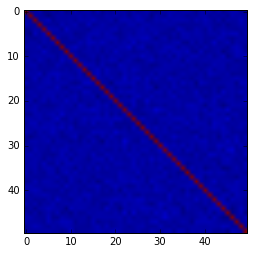

In [15]:
simSVD(n=1e4, k=50, eVar=1, l=10, seedval=0, corrMatrix=False, plotCorr=True)

,RankApprox,Orig,SVD,Ratio
0,10,0.099074,6.532374,65.934232


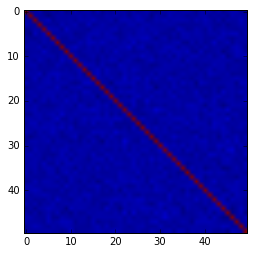

In [22]:
simSVD(n=1e4, k=50, eVar=0.1, l=10, seedval=0, corrMatrix=False, plotCorr=True)

/Users/franciscojavierarceo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: covariance is not positive-semidefinite.


,RankApprox,Orig,SVD,Ratio
0,10,1.001723,4.622032,4.61408


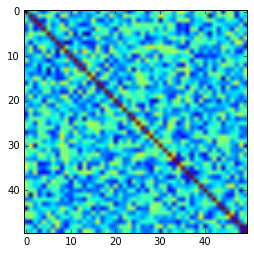

In [23]:
simSVD(corrMatrix=True, plotCorr=True)

In [56]:
# With a varying error term
ncols, rankr, orig, svds, rati, error = [], [], [], [], [], []
for e in tqdm(range(10,31)):
    for j in range(10, 20):
        for i in range(j):
            simperf = simSVD(n=3e4, k = j, eVar=(e/10.0), l=i, 
                         seedval=1, corrMatrix=False, 
                         plotCorr=False).values.tolist()[0]
            ncols.append(j)
            rankr.append(i)
            error.append(e/10.0)
            orig.append(simperf[1])
            svds.append(simperf[2])
            rati.append(simperf[3])

In [77]:
out = pd.DataFrame([ncols,rankr,orig,svds,rati,error], index=['NCols','RankApprox','Orig','SVD','Ratio', "Error"]).T
bnds = [int(np.min(out['Ratio'])), int(math.ceil(np.max(out['Ratio'])))]

es = list(set(out.Error))
es.sort(reverse=True)  # Go from high to low
for idx, i in enumerate(es):
    X, Y, Z = out.ix[out['Error']==i,'RankApprox'], out.ix[out['Error']==i,'NCols'], out.ix[out['Error']==i,'Ratio']
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(X, Y, Z, cmap=cm.bwr, norm=plt.Normalize(vmin=1, vmax=3.5))
    ax.set_zlim(bnds[0], bnds[1])
    ax.set_title('3d Plot of SVD with Model Error ='+str(i)+'\n' +'Iteration '+str(idx) +'\n \n')
    ax.set_ylabel('Low Rank Approximation Size')
    ax.set_xlabel('True Rank')
    ax.set_zlabel('Ratio of True Rank Model and Low Rank Error')
    plt.close()
    fig.savefig('3dplot_'+str(idx).zfill(2)+'.png')
    
# This will export a gif of all of the images
file_names = [f for f in os.listdir('./') if f.startswith('3dplot_')]
file_names.sort()
images = [Image.open(fn) for fn in file_names]
writeGif("3dplot_gif.GIF", images, duration=0.5)

### Now using a varying error term and correlated design matrix

In [79]:
ncols, rankr, orig, svds, rati, error = [], [], [], [], [], []
for e in tqdm(range(10,31)):
    for j in range(10, 20):
        for i in range(j):
            tmp = simSVD(n=1e5, k = j, eVar=(e/10.0), l=i, seedval=1, corrMatrix=True).values.tolist()[0]
            ncols.append(j)
            rankr.append(i)
            error.append(e/10.0)
            orig.append(tmp[1])
            svds.append(tmp[2])
            rati.append(tmp[3])

  0%|          | 0/21 [00:00<?, ?it/s]/Users/franciscojavierarceo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: covariance is not positive-semidefinite.


In [91]:
out = pd.DataFrame([ncols,rankr,orig,svds,rati,error], index=['NCols','R','Orig','SVD','Ratio', "Error"]).T
bnds = [int(np.min(out['Ratio'])), int(math.ceil(np.max(out['Ratio'])))]

es = list(set(out.Error))
es.sort(reverse=True)

for idx, e in enumerate(es):
    X, Y, Z = out.ix[out['Error']==e,'R'], out.ix[out['Error']==e,'NCols'], out.ix[out['Error']==e,'Ratio']
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(X, Y, Z, cmap=cm.bwr, norm=plt.Normalize(vmin=1, vmax=3.5))
    ax.set_zlim(bnds[0],bnds[1])
    ax.set_title('3d Plot of SVD with Model Error ='+str(e)+'\n' +'Iteration '+str(idx) +'\n \n')
    ax.set_ylabel('Low Rank Approximation Size')
    ax.set_xlabel('True Rank')
    ax.set_zlabel('Ratio of True Rank Model and Low Rank Error')
    plt.close()
    fig.savefig('3dplotcorr_'+str(idx).zfill(2)+'.png')
    
# This will export a gif of all of the images
file_names = [f for f in os.listdir('./') if f.startswith('3dplotcorr_')]
file_names.sort()
images = [Image.open(fn) for fn in file_names]
writeGif("3dplotcorr_gif.GIF", images, duration=0.5)